In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from datasets import Dataset, DatasetDict
from sklearn.metrics import mean_squared_error, r2_score
import xgboost as xgb
from datasets import load_dataset

In [3]:
df = pd.read_csv('../data/raw/imdb/Top 1000 IMDB movies.csv', index_col=0)

In [4]:
def grossToFloat(string):
    if type(string) != float:
        string = string.replace('$', '')
        string = string.replace('M', '')
        return float(string)
    return string

df.Gross.replace('%^%^%^', np.nan, inplace=True)

df.Gross = df.Gross.apply(lambda item: np.nan if '#' in str(item) else item)
df['Gross'] = df['Gross'].apply(grossToFloat)

In [5]:
# Extract the numbers 
df['Year of Release'] = df['Year of Release'].apply(lambda item: re.findall(r'\d+', item)[0])
# df['Gross'] = df['Gross'].apply(lambda item: re.findall(r'\d+', str(item))[0] if len(re.findall(r'\d+', str(item))) > 0 else np.nan)
df['Watch Time'] = df['Watch Time'].apply(lambda item: re.findall(r'\d+', item)[0])

In [6]:
df.dropna(inplace=True)

In [7]:
# rename columns
df.rename(columns={'Description': 'text', 'Gross': 'label'}, inplace=True)

In [8]:
# Train test split
X_text = Dataset.from_pandas(df)
train_test = X_text.train_test_split(test_size=0.15, shuffle=True, seed=42)
train_validation = train_test['train'].train_test_split(test_size=0.15/0.85, shuffle=True, seed=42)
X_text = DatasetDict({'train': train_validation['train'], 'validation': train_validation['test'], 'test': train_test['test']})

mean_price = np.mean(X_text['train']['label'])
std_price = np.std(X_text['train']['label'])

def normalize_price(example):
    example['scaled_label'] = (example['label'] - mean_price) / std_price
    return example

X_text = X_text.map(normalize_price)

# X_text.save_to_disk('../data/processed/airbnb/summaries')
X_text.push_to_hub('imdb_gross')

Pushing split train to the Hub.                    
Resuming upload of the dataset shards.
Pushing dataset shards to the dataset hub: 100%|██████████| 1/1 [00:00<00:00, 12787.51it/s]
Pushing split validation to the Hub.
Resuming upload of the dataset shards.
Pushing dataset shards to the dataset hub: 100%|██████████| 1/1 [00:00<00:00, 4198.50it/s]
Pushing split test to the Hub.
Resuming upload of the dataset shards.
Pushing dataset shards to the dataset hub: 100%|██████████| 1/1 [00:00<00:00, 10810.06it/s]


In [91]:
dataset = load_dataset('james-burton/imdb_gross')

# X_train is all cols except label and text
X_train = dataset['train'].remove_columns(['label', 'text','__index_level_0__', 'scaled_label', 'Movie Name', 'Votes']).to_pandas()
y_train = dataset['train'].to_pandas()['label'].astype('float')
X_test = dataset['test'].remove_columns(['label', 'text','__index_level_0__', 'scaled_label', 'Movie Name', 'Votes']).to_pandas()
y_test = dataset['test'].to_pandas()['label'].astype('float')

# if X_train['Meatscore of movie'] == '****' then nan
X_train = X_train.replace('****', np.nan)
X_test = X_test.replace('****', np.nan)

# Set column types of X_train
X_train['Year of Release'] = X_train['Year of Release'].astype('int')
X_train['Watch Time'] = X_train['Watch Time'].astype('int')
X_train['Meatscore of movie'] = X_train['Meatscore of movie'].astype('float')
X_test['Year of Release'] = X_test['Year of Release'].astype('int')
X_test['Watch Time'] = X_test['Watch Time'].astype('int')
X_test['Meatscore of movie'] = X_test['Meatscore of movie'].astype('float')

# X_train = X_train[X_train['Meatscore of movie'] != '****'].astype('int')
# X_test = X_test[X_test['Meatscore of movie'] != '****'].astype('int')
y_train = y_train[X_train.index]
y_test = y_test[X_test.index]

# # drop if y_train is over 400
# X_train = X_train[y_train < 400]
# y_train = y_train[y_train < 400]

# take the log of y_train, make it so that the distribution is more normal. Ensue no inf values
# # y_train = y_train.replace(0, 1)
# y_train = np.log(y_train)
# # y_test = y_test.replace(0, 1)
# y_test = np.log(y_test)

# change label to be categorical, under or over 200
y_train = y_train.apply(lambda item: 1 if item > 300 else 0)
y_test = y_test.apply(lambda item: 1 if item > 300 else 0)

model = xgb.XGBClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print('RMSE: ', np.sqrt(mean_squared_error(y_test, y_pred)))
# print('R^2: ',r2_score(y_test, y_pred))
# acc
print('Accuracy: ', np.mean(y_test == y_pred))

Found cached dataset parquet (/home/james/.cache/huggingface/datasets/james-burton___parquet/james-burton--imdb_gross-29e149befb40e1e2/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)
100%|██████████| 3/3 [00:00<00:00, 747.96it/s]

RMSE:  0.23855936180684895
Accuracy:  0.943089430894309


In [84]:
y_test

0      0
1      0
2      0
3      0
4      0
      ..
118    0
119    1
120    0
121    0
122    0
Name: label, Length: 114, dtype: int64

In [85]:
y_pred

array([ 1.22211225e-01,  5.65967500e-01,  2.65946314e-02, -5.04487380e-03,
       -1.95902344e-02,  1.51762515e-02,  1.49353202e-02,  3.47035855e-01,
        5.47969460e-01,  4.57251854e-02, -3.30512994e-04,  1.39848061e-03,
        1.04214318e-01,  6.69777572e-01, -4.45971228e-02,  1.56542152e-01,
        1.28771693e-01, -1.90629438e-02,  5.22866026e-02,  5.32908618e-01,
       -1.95700489e-03, -6.20827787e-02,  2.06558090e-02, -1.42605156e-02,
       -2.68553421e-02,  1.15204372e-01,  1.20225921e-03,  5.20619564e-03,
        3.99036646e-01,  1.14727482e-01,  1.96688324e-01,  1.92248240e-01,
       -1.05118491e-01, -3.33153876e-03,  2.35818371e-01, -4.43798378e-02,
       -6.35583028e-02,  3.94208848e-01,  3.53585333e-01,  1.61770537e-01,
       -3.70033160e-02, -5.87505102e-02,  5.11174127e-02,  6.29705712e-02,
        4.08481546e-02, -3.18340771e-03,  1.19515896e-01,  1.68392882e-01,
        9.80863161e-03, -4.35164794e-02,  1.05780527e-01,  1.38448983e-01,
       -1.31695652e-02,  

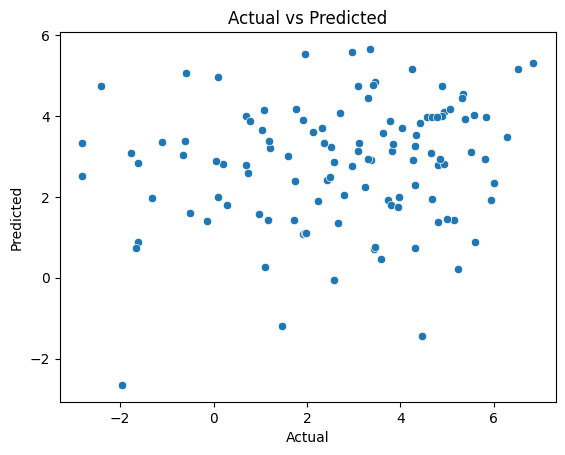

In [80]:
# plot y_test vs y_pred
sns.scatterplot(x=y_test, y=y_pred)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted')
plt.show()

0.0

In [73]:
y_train.value_counts()

0.01     4
0.07     3
0.05     3
0.06     3
4.04     2
        ..
35.06    1
15.54    1
40.31    1
9.45     1
0.31     1
Name: label, Length: 473, dtype: int64

/tmp/ipykernel_66355/3075216229.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_train)


<Axes: xlabel='label', ylabel='Density'>

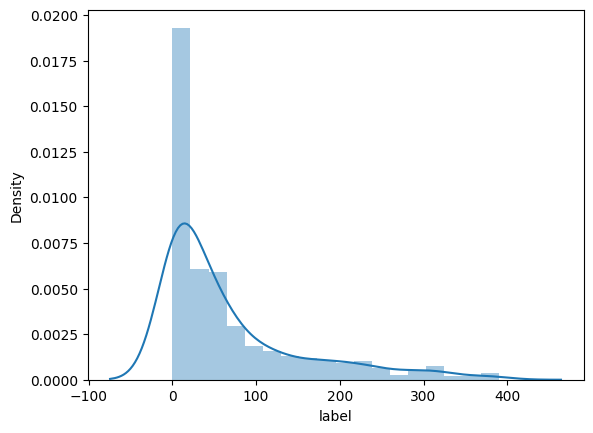

In [72]:
# plot dsitrubution of y_train
sns.distplot(y_train)

In [45]:
y_train.index

Int64Index([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,
            ...
            560, 561, 562, 563, 564, 566, 567, 568, 569, 570],
           dtype='int64', length=510)

In [37]:
# Set column types of X_train
X_train['Year of Release'] = X_train['Year of Release'].astype('int')
X_train['Watch Time'] = X_train['Watch Time'].astype('int')
# if X_train['Meatscore of movie'] == '****' then drop row
X_train = X_train[X_train['Meatscore of movie'] != '****'].astype('int')

# choose y_train when X_train['Meatscore of movie'] != '****']
y_train = y_train[X_train.index]

In [42]:
# show correlations between X_train and y_train
X_train['label'] = y_train
X_train.corr()

,Year of Release,Watch Time,Movie Rating,Meatscore of movie,label
Year of Release,1.000000,0.059677,-0.158014,-0.315910,0.269065
Watch Time,0.059677,1.000000,0.211477,-0.060086,0.176469
Movie Rating,-0.158014,0.211477,1.000000,0.265697,0.046952
Meatscore of movie,-0.315910,-0.060086,0.265697,1.000000,-0.031949
label,0.269065,0.176469,0.046952,-0.031949,1.000000


In [61]:
y_train.std()

115.06743456009843

In [56]:
df['Meatscore of movie']

0       81        
1      100        
2       84        
3       94        
4       94        
          ...     
989     65        
991     90        
993     90        
996     85        
997     95        
Name: Meatscore of movie, Length: 817, dtype: object